In [4]:
from sklearn.model_selection import train_test_split
import os

data_dir = "data/train"

classes = os.listdir(data_dir)

train_data = []
test_data = []

for cls in classes:
    cls_path = os.path.join(data_dir, cls)
    images = [os.path.join(cls_path, img) for img in os.listdir(cls_path)]
    
    train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)
    
    train_data.extend(train_images)
    test_data.extend(test_images)


In [5]:
import shutil

validation_dir = "data/validation"

for cls in classes:
    cls_val_dir = os.path.join(validation_dir, cls)
    os.makedirs(cls_val_dir, exist_ok=True)

for img_path in test_data:
    img_name = os.path.basename(img_path)
    img_cls = os.path.basename(os.path.dirname(img_path))
    dest_dir = os.path.join(validation_dir, img_cls)
    shutil.move(img_path, os.path.join(dest_dir, img_name))


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height = 150
img_width = 150
batch_size = 32
num_epochs = 10

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data/train',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse')

validation_generator = test_datagen.flow_from_directory(
    'data/validation',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='sparse')

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

predictions = model.predict(validation_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = validation_generator.classes

accuracy = np.mean(predicted_classes == true_classes)
print("Test Accuracy:", accuracy)

print("Classification Report:")
print(classification_report(true_classes, predicted_classes))

print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

misclassified_images = []

for i in range(len(true_classes)):
    if predicted_classes[i] != true_classes[i]:
        misclassified_images.append((validation_generator.filenames[i], true_classes[i], predicted_classes[i]))

misclassification_rate = len(misclassified_images) / len(true_classes)
print("Misclassification Rate:", misclassification_rate)

print("Misclassified Images:")
for img_path, true_label, predicted_label in misclassified_images:
    print("Image:", img_path)
    print("True Label:", validation_generator.class_indices[true_label])
    print("Predicted Label:", validation_generator.class_indices[predicted_label])
    print()


C:\Users\shyaa\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,739 (18.42 MB)

 Trainable params: 4,828,739 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

Found 3656 images belonging to 3 classes.
Found 3487 images belonging to 3 classes.
Epoch 1/10


C:\Users\shyaa\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.8735 - loss: 0.3548

C:\Users\shyaa\anaconda3\Lib\site-packages\PIL\Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


114/114 ━━━━━━━━━━━━━━━━━━━━ 43s 358ms/step - accuracy: 0.8738 - loss: 0.3540 - val_accuracy: 0.9392 - val_loss: 0.1875
Epoch 2/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9688 - loss: 0.0861 - val_accuracy: 0.8710 - val_loss: 0.3442
Epoch 3/10


C:\Users\shyaa\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


114/114 ━━━━━━━━━━━━━━━━━━━━ 42s 365ms/step - accuracy: 0.9361 - loss: 0.1854 - val_accuracy: 0.9375 - val_loss: 0.1885
Epoch 4/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 721us/step - accuracy: 0.9375 - loss: 0.2272 - val_accuracy: 0.9032 - val_loss: 0.2980
Epoch 5/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 40s 348ms/step - accuracy: 0.9510 - loss: 0.1352 - val_accuracy: 0.9433 - val_loss: 0.1529
Epoch 6/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 577us/step - accuracy: 0.9062 - loss: 0.1748 - val_accuracy: 0.9355 - val_loss: 0.1205
Epoch 7/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 46s 399ms/step - accuracy: 0.9627 - loss: 0.0993 - val_accuracy: 0.9505 - val_loss: 0.1482
Epoch 8/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9688 - loss: 0.0922 - val_accuracy: 1.0000 - val_loss: 0.0323
Epoch 9/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 77s 662ms/step - accuracy: 0.9807 - loss: 0.0721 - val_accuracy: 0.9537 - val_loss: 0.1520
Epoch 10/10
114/114 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9688 - loss: 0.0377 - val_accura

KeyError: 0

In [7]:
print("Misclassified Images:")
for img_path, true_label, predicted_label in misclassified_images:
    print("Image:", img_path)
    print("True Label:", true_label)
    print("Predicted Label:", predicted_label)
    print()

Misclassified Images:
Image: air_pollution\air_pollution_1037.jpg
True Label: 0
Predicted Label: 1

Image: air_pollution\air_pollution_1063.jpg
True Label: 0
Predicted Label: 1

Image: air_pollution\air_pollution_1064.jpg
True Label: 0
Predicted Label: 2

Image: air_pollution\air_pollution_1150.jpg
True Label: 0
Predicted Label: 1

Image: air_pollution\air_pollution_1158.jpg
True Label: 0
Predicted Label: 1

Image: air_pollution\air_pollution_1183.jpg
True Label: 0
Predicted Label: 2

Image: air_pollution\air_pollution_1218.jpg
True Label: 0
Predicted Label: 1

Image: air_pollution\air_pollution_1230.jpg
True Label: 0
Predicted Label: 2

Image: air_pollution\air_pollution_1252.jpg
True Label: 0
Predicted Label: 2

Image: air_pollution\air_pollution_1264.jpg
True Label: 0
Predicted Label: 2

Image: air_pollution\air_pollution_1298.jpg
True Label: 0
Predicted Label: 1

Image: air_pollution\air_pollution_1300.jpg
True Label: 0
Predicted Label: 2

Image: air_pollution\air_pollution_1311.jp

In [8]:
class_accuracy = {}
for cls in range(len(validation_generator.class_indices)):
    cls_true = true_classes == cls
    cls_pred = predicted_classes == cls
    cls_accuracy = np.mean(cls_pred[cls_true])
    class_accuracy[cls] = (cls_accuracy, np.sum(cls_true))

print("Accuracy per Class:")
for cls, (accuracy, num_samples) in class_accuracy.items():
    print(f"Class {cls} - Accuracy: {accuracy:.2f}, Samples: {num_samples}")


Accuracy per Class:
Class 0 - Accuracy: 0.93, Samples: 3187
Class 1 - Accuracy: 0.04, Samples: 142
Class 2 - Accuracy: 0.04, Samples: 158


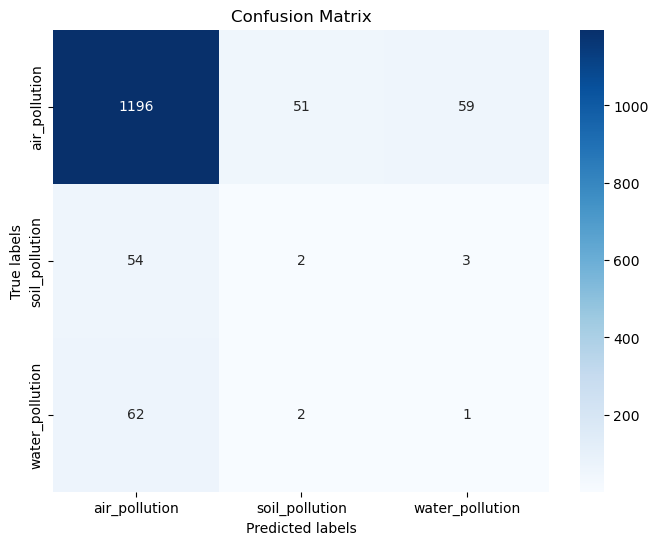

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=validation_generator.class_indices, yticklabels=validation_generator.class_indices)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


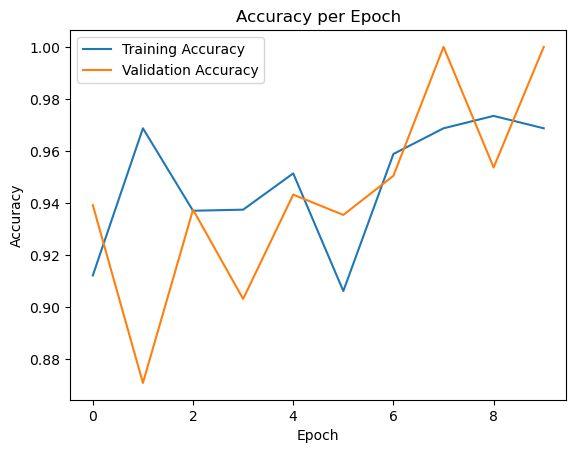

In [10]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()
plt.show()


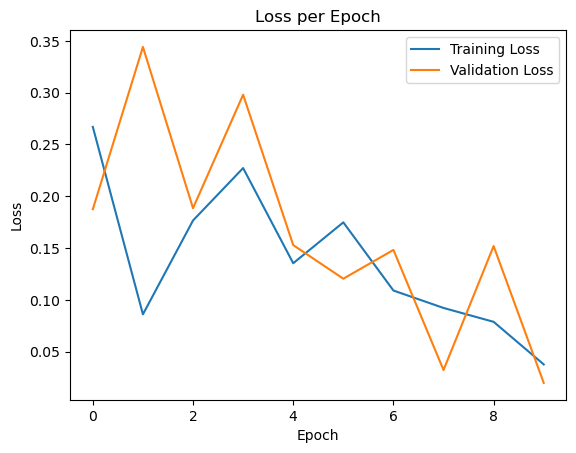

In [11]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()


In [12]:
import os
import shutil

count = 0
for image_path in misclassified_images:
    try:
        path = "data/validation/" + (image_path[0]).replace("\\", "/")
        shutil.copy(path, "data/misclassified/" + (image_path[0]).replace("\\", "/").split("/")[1])
    except:
        path = "data/train/" + (image_path[0]).replace("\\", "/")
        shutil.copy(path, "data/misclassified/" + (image_path[0]).replace("\\", "/").split("/")[1])
    count += 1
    print(count)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [13]:
import os
import numpy as np
import cv2

def extract_features(base_dir, class_names):
    features = []
    labels = []
    for class_name in class_names:
        class_dir = os.path.join(base_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            img = cv2.resize(img, (224, 224))
            features.append(img.flatten())
            labels.append(class_name)
    return np.array(features), np.array(labels)

base_dir = 'data/train'
class_names = ['air_pollution', 'water_pollution', 'soil_pollution']
features, labels = extract_features(base_dir, class_names)


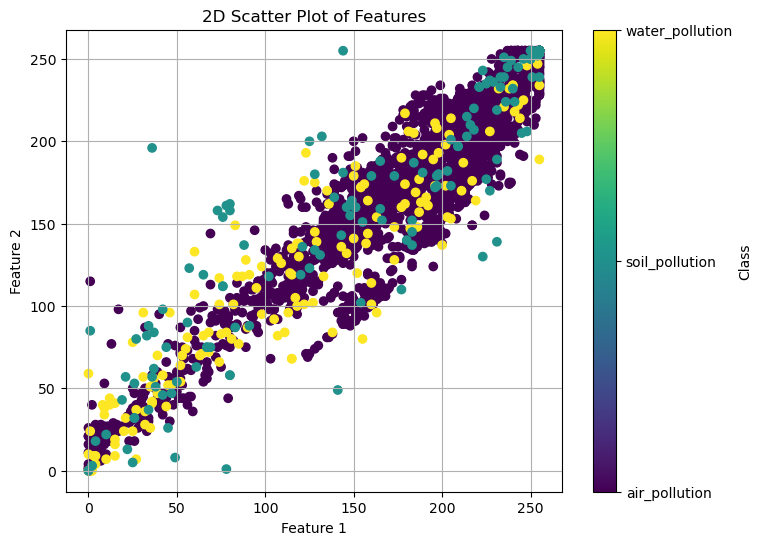

In [14]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
numeric_labels = label_encoder.fit_transform(labels)

plt.figure(figsize=(8, 6))
plt.scatter(features[:, 0], features[:, 1], c=numeric_labels, cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Scatter Plot of Features')
plt.colorbar(label='Class', ticks=range(len(class_names)), format=plt.FuncFormatter(lambda i, _: label_encoder.inverse_transform([int(i)])[0]))
plt.grid(True)
plt.show()


In [15]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

X_train, X_test, y_train, y_test = train_test_split(features, numeric_labels, test_size=0.2, random_state=42)

Accuracy: 0.9467213114754098
Classification Report:
                 precision    recall  f1-score   support

  air_pollution       0.95      1.00      0.97       668
water_pollution       0.94      0.53      0.68        32
 soil_pollution       0.69      0.34      0.46        32

       accuracy                           0.95       732
      macro avg       0.86      0.62      0.70       732
   weighted avg       0.94      0.95      0.94       732

Confusion Matrix:
[[665   1   2]
 [ 12  17   3]
 [ 21   0  11]]


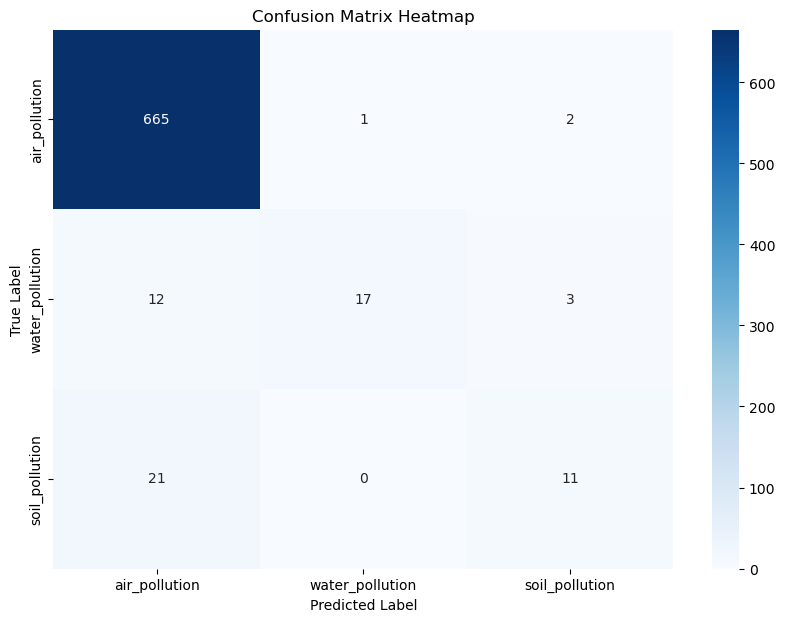

In [17]:
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred, target_names=class_names)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [20]:
import os
import numpy as np
import cv2
import xgboost as xgb

xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(class_names), eval_metric='mlogloss', use_label_encoder=False)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

report = classification_report(y_test, y_pred, target_names=class_names)
print('Classification Report:')
print(report)

conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

results = xgb_model.evals_result()

plt.figure(figsize=(10, 5))
plt.plot(results['validation_0']['mlogloss'], label='Training Loss')
plt.plot(results['validation_1']['mlogloss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()

XGBoostError: [11:39:54] C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\io.h:232: bad_malloc: Failed to allocate 16072685712 bytes.